# 훈련 데이터셋에 대한 군집화 (K-Means)

In [49]:
# 필수 라이브러리 로드 및 설정
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score

sns.set_theme(style="whitegrid", palette="crest")
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

In [50]:
def find_project_root(start: Path) -> Path:
    # 상위 폴더로 거슬러 올라가 .git 디렉터리가 있는 경로를 찾습니다.
    for candidate in [start, *start.parents]:
        if (candidate / ".git").is_dir():
            return candidate
    raise FileNotFoundError(".git 폴더를 찾을 수 없습니다. 프로젝트 루트를 확인하세요.")

PROJECT_ROOT = find_project_root(Path.cwd())
DATA_PATH = PROJECT_ROOT / "data/training/final/travel_ml.csv"


In [51]:
travel = pd.read_csv(DATA_PATH)

In [52]:
# 전체 컬럼
CLUSTERING_FEATURES = [
    'TRAVEL_STATUS_ACCOMPANY_CODE',
    'MVMN_NM_CODE',
    'GENDER_CODE',
    'TRAVEL_STATUS_RESIDENCE_CODE',
    'TRAVEL_STATUS_DESTINATION_CODE',
    'TRAVEL_PURPOSE_CD_1',
    'TRAVEL_PURPOSE_CD_2',
    'TRAVEL_PURPOSE_CD_3',
    'TRAVEL_PURPOSE_CD_4',
    'TRAVEL_PURPOSE_CD_5',
    'TRAVEL_PURPOSE_CD_6',
    'TRAVEL_PURPOSE_CD_7',
    'TRAVEL_PURPOSE_CD_8',
    'TRAVEL_PURPOSE_CD_9',
    'TRAVEL_PURPOSE_CD_10',
    'TRAVEL_PURPOSE_CD_11',
    'TRAVEL_PURPOSE_CD_12',
    'TRAVEL_PURPOSE_CD_13',
    'TRAVEL_PURPOSE_CD_21',
    'TRAVEL_PURPOSE_CD_22',
    'TRAVEL_PURPOSE_CD_23',
    'TRAVEL_PURPOSE_CD_24',
    'TRAVEL_PURPOSE_CD_25',
    'TRAVEL_PURPOSE_CD_26',
    'TRAVEL_PURPOSE_CD_27',
    'TRAVEL_PURPOSE_CD_28',
    'TRAVEL_MISSION_CHECK_CD_1',
    'TRAVEL_MISSION_CHECK_CD_2',
    'TRAVEL_MISSION_CHECK_CD_3',
    'TRAVEL_MISSION_CHECK_CD_4',
    'TRAVEL_MISSION_CHECK_CD_5',
    'TRAVEL_MISSION_CHECK_CD_6',
    'TRAVEL_MISSION_CHECK_CD_7',
    'TRAVEL_MISSION_CHECK_CD_8',
    'TRAVEL_MISSION_CHECK_CD_9',
    'TRAVEL_MISSION_CHECK_CD_10',
    'TRAVEL_MISSION_CHECK_CD_11',
    'TRAVEL_MISSION_CHECK_CD_12',
    'TRAVEL_MISSION_CHECK_CD_13',
    'TRAVEL_MISSION_CHECK_CD_21',
    'TRAVEL_MISSION_CHECK_CD_22',
    'TRAVEL_MISSION_CHECK_CD_23',
    'TRAVEL_MISSION_CHECK_CD_24',
    'TRAVEL_MISSION_CHECK_CD_25',
    'TRAVEL_MISSION_CHECK_CD_26',
    'TRAVEL_MISSION_CHECK_CD_27',
    'TRAVEL_MISSION_CHECK_CD_28',
    'TRAVEL_START_YEAR',
    'TRAVEL_START_MONTH',
    'TRAVEL_END_YEAR',
    'TRAVEL_END_MONTH',
    'activity_payment_sum_SCALED',
    'activity_payment_count_SCALED',
    'activity_store_count_SCALED',
    'activity_history_rows_SCALED',
    'activity_type_unique_SCALED',
    'lodging_payment_sum_SCALED',
    'lodging_payment_count_SCALED',
    'lodging_store_count_SCALED',
    'visit_trip_days_SCALED',
    'visit_move_cnt_SCALED',
    'AGE_GRP_SCALED',
    'FAMILY_MEMB_SCALED',
    'INCOME_SCALED',
    'HOUSE_INCOME_SCALED',
    'TRAVEL_TERM_SCALED',
    'TRAVEL_NUM_SCALED',
    'TRAVEL_COMPANIONS_NUM_SCALED'
]

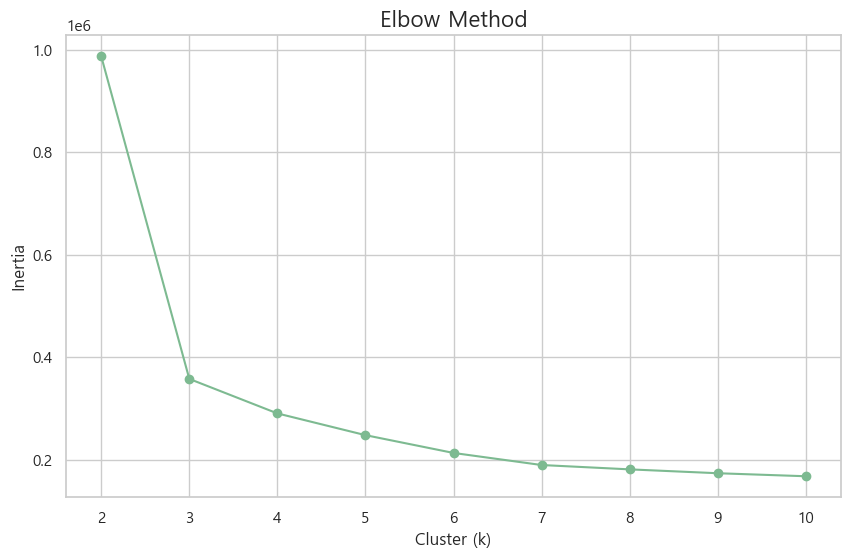

In [53]:
# Elbow method
from sklearn.cluster import KMeans

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X=travel[CLUSTERING_FEATURES])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method', fontsize=16)
plt.xlabel('Cluster (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

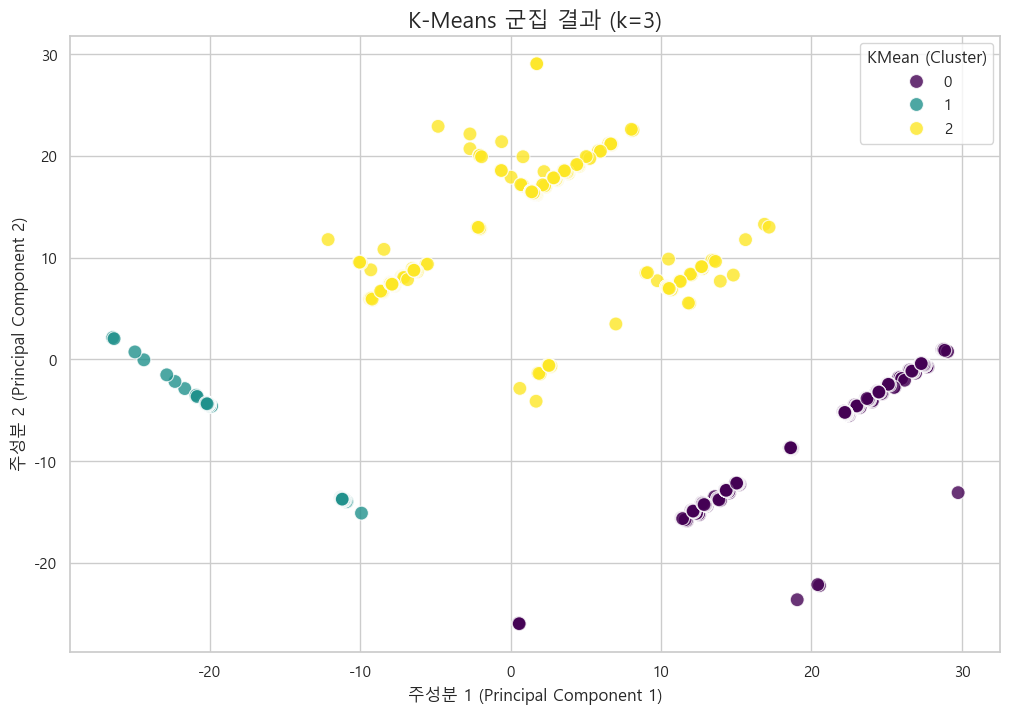

In [54]:
# PCA
from sklearn.decomposition import PCA

# Elbow 결과 기반 k 선택 예시 (여기서는 k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X=travel[CLUSTERING_FEATURES])

travel['KMEANS_CLUSTER'] = cluster_labels

pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(X=travel[CLUSTERING_FEATURES])

pca_df = pd.DataFrame(data=cluster_pca, columns=['PC1', 'PC2'])
pca_df['CLUSTER'] = cluster_labels

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='CLUSTER', data=pca_df, palette='viridis', s=100, alpha=0.8)
plt.title(f"K-Means 군집 결과 (k={optimal_k})", fontsize=16)
plt.xlabel("주성분 1 (Principal Component 1)", fontsize=12)
plt.ylabel("주성분 2 (Principal Component 2)", fontsize=12)
plt.legend(title='KMean (Cluster)')
plt.grid(True)
plt.show()

In [55]:
# 실루엣 스코어 출력 (PCA 시각화와 별개)
sil_score = silhouette_score(
    X=pca_df[['PC1', 'PC2']],
    labels=travel['KMEANS_CLUSTER']
)
sil_score

0.7957306958503414

In [56]:
numeric_features = [
    'activity_payment_sum', 'activity_payment_count', 'activity_store_count',
    'activity_history_rows', 'activity_type_unique', 'lodging_payment_sum',
    'lodging_payment_count', 'lodging_store_count', 'visit_trip_days',
    'visit_move_cnt', 'AGE_GRP', 'FAMILY_MEMB', 'INCOME',
    'HOUSE_INCOME', 'TRAVEL_TERM', 'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM'
]

cluster_numeric_summary = travel.groupby('KMEANS_CLUSTER')[numeric_features].mean()

print(cluster_numeric_summary.T)

KMEANS_CLUSTER                      0              1              2
activity_payment_sum    169775.199041  116359.179903  126361.421717
activity_payment_count       5.038969       3.614803       4.046717
activity_store_count         4.747002       3.345219       3.732323
activity_history_rows       11.032974       7.894652       8.164773
activity_type_unique         4.432254       3.916261       3.970328
lodging_payment_sum     140583.234412  127120.452188  130789.015783
lodging_payment_count        0.365108       0.287412       0.317551
lodging_store_count          0.346523       0.275527       0.309975
visit_trip_days              2.540767       2.293895       2.388889
visit_move_cnt               9.811151       6.985413       7.229167
AGE_GRP                     28.741007      32.425716      31.420455
FAMILY_MEMB                  2.766187       2.614263       2.779672
INCOME                       3.757194       4.287412       4.121843
HOUSE_INCOME                 7.349520       7.56

In [57]:
# 분석용 범주형 피처 목록
categorical_features = [
    'TRAVEL_STATUS_ACCOMPANY_CODE', 'MVMN_NM_CODE', 'GENDER_CODE',
    'TRAVEL_STATUS_RESIDENCE_CODE', 'TRAVEL_STATUS_DESTINATION_CODE'
]

# K-Means 군집별 범주형 피처 최빈값
cluster_categorical_summary = travel.groupby('KMEANS_CLUSTER')[categorical_features].agg(lambda x: x.mode()[0])

print(cluster_categorical_summary)


                TRAVEL_STATUS_ACCOMPANY_CODE  MVMN_NM_CODE  GENDER_CODE  \
KMEANS_CLUSTER                                                            
0                                          6             1            2   
1                                          2             2            2   
2                                          2             2            2   

                TRAVEL_STATUS_RESIDENCE_CODE  TRAVEL_STATUS_DESTINATION_CODE  
KMEANS_CLUSTER                                                                
0                                         41                            11.0  
1                                         11                            41.0  
2                                         41                            41.0  


In [58]:
# 각 군집의 분포 확인용 출력
for feature in categorical_features:
    print(f'--- {feature} 분포 ---')
    print(travel.groupby('KMEANS_CLUSTER')[feature].value_counts())
    print()


--- TRAVEL_STATUS_ACCOMPANY_CODE 분포 ---
KMEANS_CLUSTER  TRAVEL_STATUS_ACCOMPANY_CODE
0               6                               627
                2                               557
                8                               160
                1                               147
                5                               141
                3                                18
                7                                18
1               2                               560
                6                               483
                8                               309
                5                               229
                1                               165
                7                                62
                3                                40
                4                                 3
2               2                               481
                6                               324
                8              

## IS_FAILED_TRIP 그룹별 K-Means, 실루엣, 분포 분석

- IS_FAILED_TRIP=0(성공), 1(실패) 각각에 대해 K-Means 수행

In [59]:
travel_grouped = pd.read_csv(DATA_PATH)

In [60]:
# 전체 컬럼
CLUSTERING_FEATURES = [
    'TRAVEL_STATUS_ACCOMPANY_CODE',
    'MVMN_NM_CODE',
    'GENDER_CODE',
    'TRAVEL_STATUS_RESIDENCE_CODE',
    'TRAVEL_STATUS_DESTINATION_CODE',
    'TRAVEL_PURPOSE_CD_1',
    'TRAVEL_PURPOSE_CD_2',
    'TRAVEL_PURPOSE_CD_3',
    'TRAVEL_PURPOSE_CD_4',
    'TRAVEL_PURPOSE_CD_5',
    'TRAVEL_PURPOSE_CD_6',
    'TRAVEL_PURPOSE_CD_7',
    'TRAVEL_PURPOSE_CD_8',
    'TRAVEL_PURPOSE_CD_9',
    'TRAVEL_PURPOSE_CD_10',
    'TRAVEL_PURPOSE_CD_11',
    'TRAVEL_PURPOSE_CD_12',
    'TRAVEL_PURPOSE_CD_13',
    'TRAVEL_PURPOSE_CD_21',
    'TRAVEL_PURPOSE_CD_22',
    'TRAVEL_PURPOSE_CD_23',
    'TRAVEL_PURPOSE_CD_24',
    'TRAVEL_PURPOSE_CD_25',
    'TRAVEL_PURPOSE_CD_26',
    'TRAVEL_PURPOSE_CD_27',
    'TRAVEL_PURPOSE_CD_28',
    'TRAVEL_MISSION_CHECK_CD_1',
    'TRAVEL_MISSION_CHECK_CD_2',
    'TRAVEL_MISSION_CHECK_CD_3',
    'TRAVEL_MISSION_CHECK_CD_4',
    'TRAVEL_MISSION_CHECK_CD_5',
    'TRAVEL_MISSION_CHECK_CD_6',
    'TRAVEL_MISSION_CHECK_CD_7',
    'TRAVEL_MISSION_CHECK_CD_8',
    'TRAVEL_MISSION_CHECK_CD_9',
    'TRAVEL_MISSION_CHECK_CD_10',
    'TRAVEL_MISSION_CHECK_CD_11',
    'TRAVEL_MISSION_CHECK_CD_12',
    'TRAVEL_MISSION_CHECK_CD_13',
    'TRAVEL_MISSION_CHECK_CD_21',
    'TRAVEL_MISSION_CHECK_CD_22',
    'TRAVEL_MISSION_CHECK_CD_23',
    'TRAVEL_MISSION_CHECK_CD_24',
    'TRAVEL_MISSION_CHECK_CD_25',
    'TRAVEL_MISSION_CHECK_CD_26',
    'TRAVEL_MISSION_CHECK_CD_27',
    'TRAVEL_MISSION_CHECK_CD_28',
    'TRAVEL_START_YEAR',
    'TRAVEL_START_MONTH',
    'TRAVEL_END_YEAR',
    'TRAVEL_END_MONTH',
    'activity_payment_sum_SCALED',
    'activity_payment_count_SCALED',
    'activity_store_count_SCALED',
    'activity_history_rows_SCALED',
    'activity_type_unique_SCALED',
    'lodging_payment_sum_SCALED',
    'lodging_payment_count_SCALED',
    'lodging_store_count_SCALED',
    'visit_trip_days_SCALED',
    'visit_move_cnt_SCALED',
    'AGE_GRP_SCALED',
    'FAMILY_MEMB_SCALED',
    'INCOME_SCALED',
    'HOUSE_INCOME_SCALED',
    'TRAVEL_TERM_SCALED',
    'TRAVEL_NUM_SCALED',
    'TRAVEL_COMPANIONS_NUM_SCALED'
]

In [61]:
# Success / Fail 그룹 분리
travel_success = travel_grouped[travel_grouped['IS_FAILED_TRIP']==0]
travel_fail = travel_grouped[travel_grouped['IS_FAILED_TRIP']==1]

### 성공 그룹

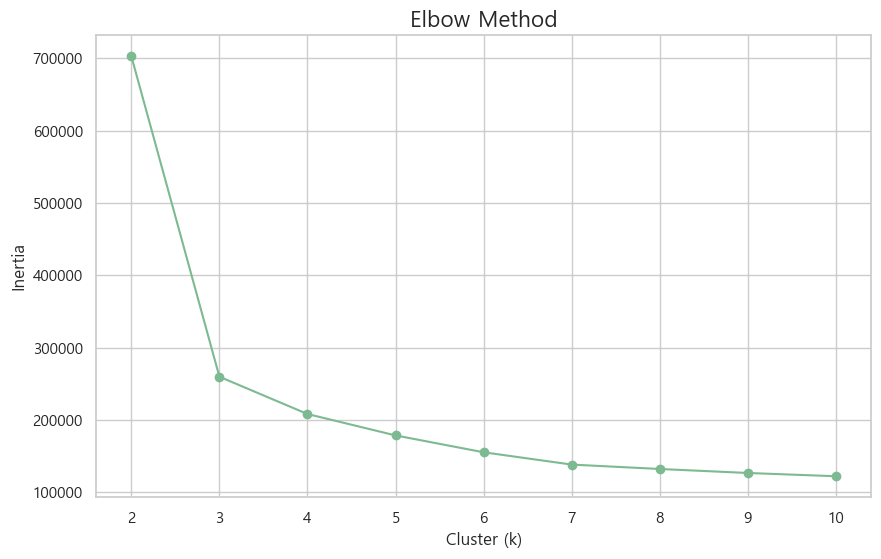

In [62]:
# Elbow method
from sklearn.cluster import KMeans

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X=travel_success[CLUSTERING_FEATURES])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method', fontsize=16)
plt.xlabel('Cluster (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

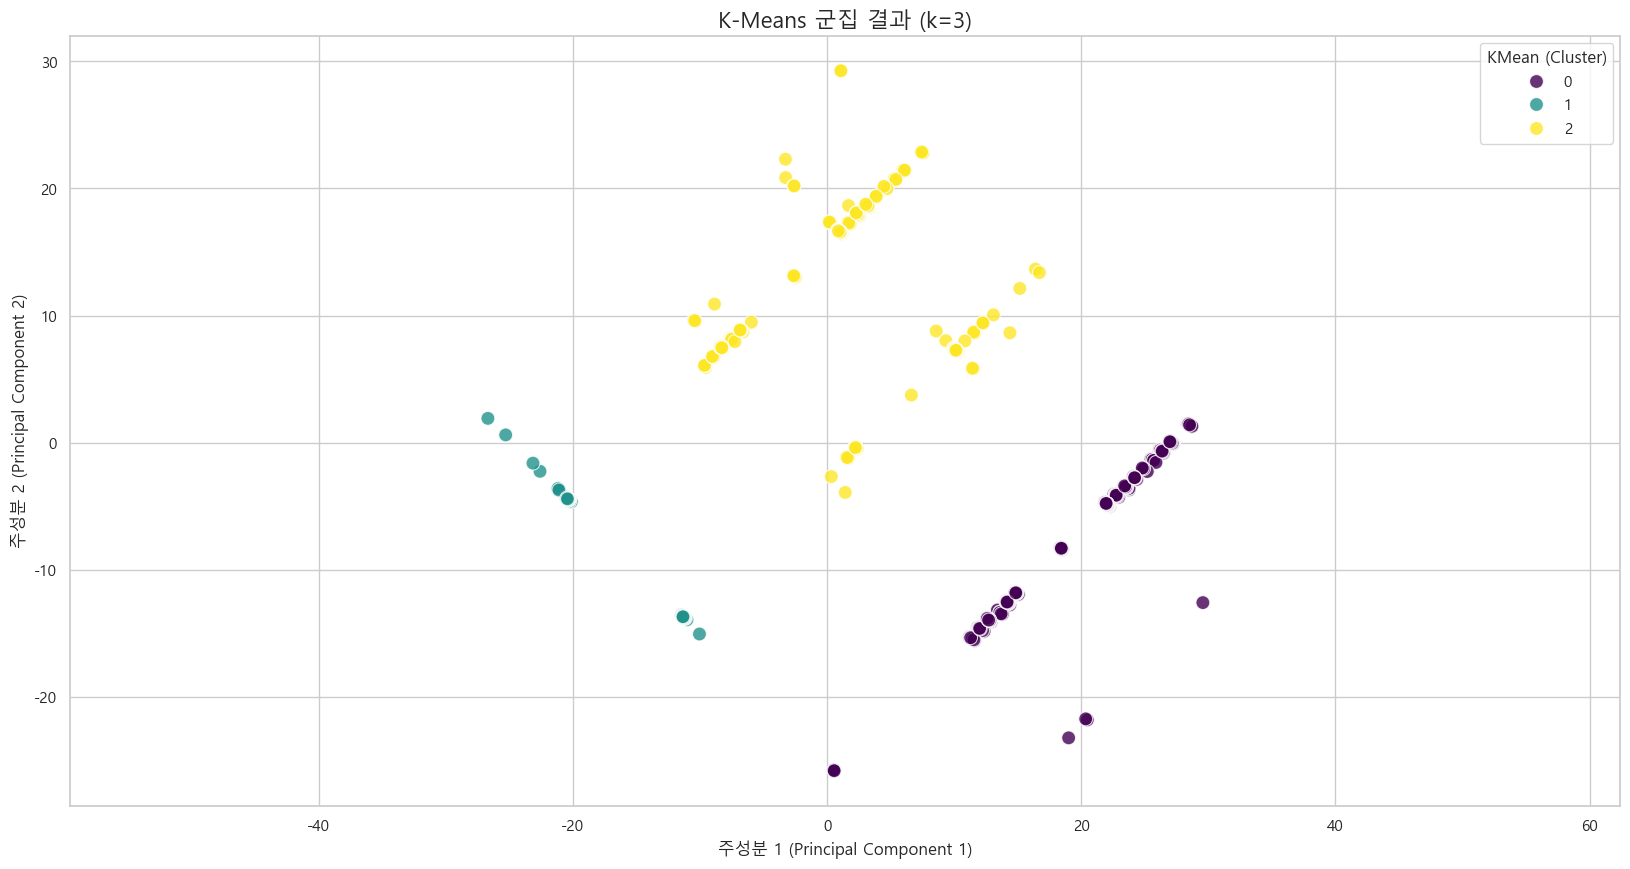

In [88]:
# PCA
from sklearn.decomposition import PCA

# Elbow 결과 기반 k 선택 예시 (여기서는 k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X=travel_success[CLUSTERING_FEATURES])

travel_success.loc[:, 'KMEANS_CLUSTER'] = cluster_labels

pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(X=travel_success[CLUSTERING_FEATURES])

pca_df = pd.DataFrame(data=cluster_pca, columns=['PC1', 'PC2'])
pca_df['CLUSTER'] = cluster_labels

plt.figure(figsize=(20, 10))
sns.scatterplot(x='PC1', y='PC2', hue='CLUSTER', data=pca_df, palette='viridis', s=100, alpha=0.8)
plt.title(f"K-Means 군집 결과 (k={optimal_k})", fontsize=16)
plt.xlabel("주성분 1 (Principal Component 1)", fontsize=12)
plt.ylabel("주성분 2 (Principal Component 2)", fontsize=12)
plt.axis('equal')
plt.legend(title='KMean (Cluster)')
plt.grid(True)
plt.show()

In [75]:
# 실루엣 스코어 출력 (PCA 시각화와 별개)
sil_score = silhouette_score(
    X=pca_df[['PC1', 'PC2']],
    labels=travel_success['KMEANS_CLUSTER']
)
sil_score

0.7921334986688304

In [76]:
numeric_features = [
    'activity_payment_sum', 'activity_payment_count', 'activity_store_count',
    'activity_history_rows', 'activity_type_unique', 'lodging_payment_sum',
    'lodging_payment_count', 'lodging_store_count', 'visit_trip_days',
    'visit_move_cnt', 'AGE_GRP', 'FAMILY_MEMB', 'INCOME',
    'HOUSE_INCOME', 'TRAVEL_TERM', 'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM'
]

cluster_numeric_summary = travel_success.groupby('KMEANS_CLUSTER')[numeric_features].mean()

print(cluster_numeric_summary.T)

KMEANS_CLUSTER                      0              1              2
activity_payment_sum    170109.616762  123224.308880  131389.033514
activity_payment_count       5.021155       3.705019       4.144022
activity_store_count         4.716843       3.429344       3.821558
activity_history_rows       11.215622       8.054826       8.315217
activity_type_unique         4.477624       3.942857       4.000000
lodging_payment_sum     142125.565500  127144.962934  131685.192935
lodging_payment_count        0.372661       0.296525       0.335145
lodging_store_count          0.357201       0.284942       0.326087
visit_trip_days              2.559805       2.311969       2.421196
visit_move_cnt               9.941416       7.057915       7.395833
AGE_GRP                     29.113100      32.687259      31.494565
FAMILY_MEMB                  2.765663       2.623166       2.815217
INCOME                       3.786819       4.297297       4.194746
HOUSE_INCOME                 7.366151       7.64

In [77]:
# 분석용 범주형 피처 목록
categorical_features = [
    'TRAVEL_STATUS_ACCOMPANY_CODE', 'MVMN_NM_CODE', 'GENDER_CODE',
    'TRAVEL_STATUS_RESIDENCE_CODE', 'TRAVEL_STATUS_DESTINATION_CODE'
]

# K-Means 군집별 범주형 피처 최빈값
cluster_categorical_summary = travel_success.groupby('KMEANS_CLUSTER')[categorical_features].agg(lambda x: x.mode()[0])

print(cluster_categorical_summary)


                TRAVEL_STATUS_ACCOMPANY_CODE  MVMN_NM_CODE  GENDER_CODE  \
KMEANS_CLUSTER                                                            
0                                          6             1            2   
1                                          2             2            2   
2                                          2             2            2   

                TRAVEL_STATUS_RESIDENCE_CODE  TRAVEL_STATUS_DESTINATION_CODE  
KMEANS_CLUSTER                                                                
0                                         41                            11.0  
1                                         11                            41.0  
2                                         41                            41.0  


In [78]:
# 각 군집의 분포 확인용 출력
for feature in categorical_features:
    print(f'--- {feature} 분포 ---')
    print(travel_success.groupby('KMEANS_CLUSTER')[feature].value_counts())
    print()


--- TRAVEL_STATUS_ACCOMPANY_CODE 분포 ---
KMEANS_CLUSTER  TRAVEL_STATUS_ACCOMPANY_CODE
0               6                               464
                2                               408
                8                               123
                1                               108
                5                                97
                3                                16
                7                                13
1               2                               386
                6                               331
                8                               225
                5                               163
                1                               117
                7                                46
                3                                24
                4                                 3
2               2                               333
                6                               229
                8              

### 실패 그룹

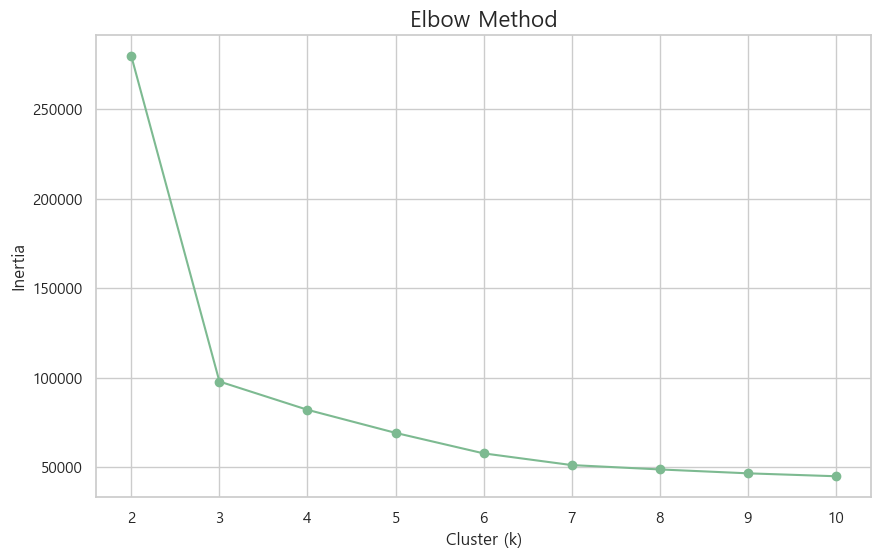

In [79]:
# Elbow method
from sklearn.cluster import KMeans

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X=travel_fail[CLUSTERING_FEATURES])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method', fontsize=16)
plt.xlabel('Cluster (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

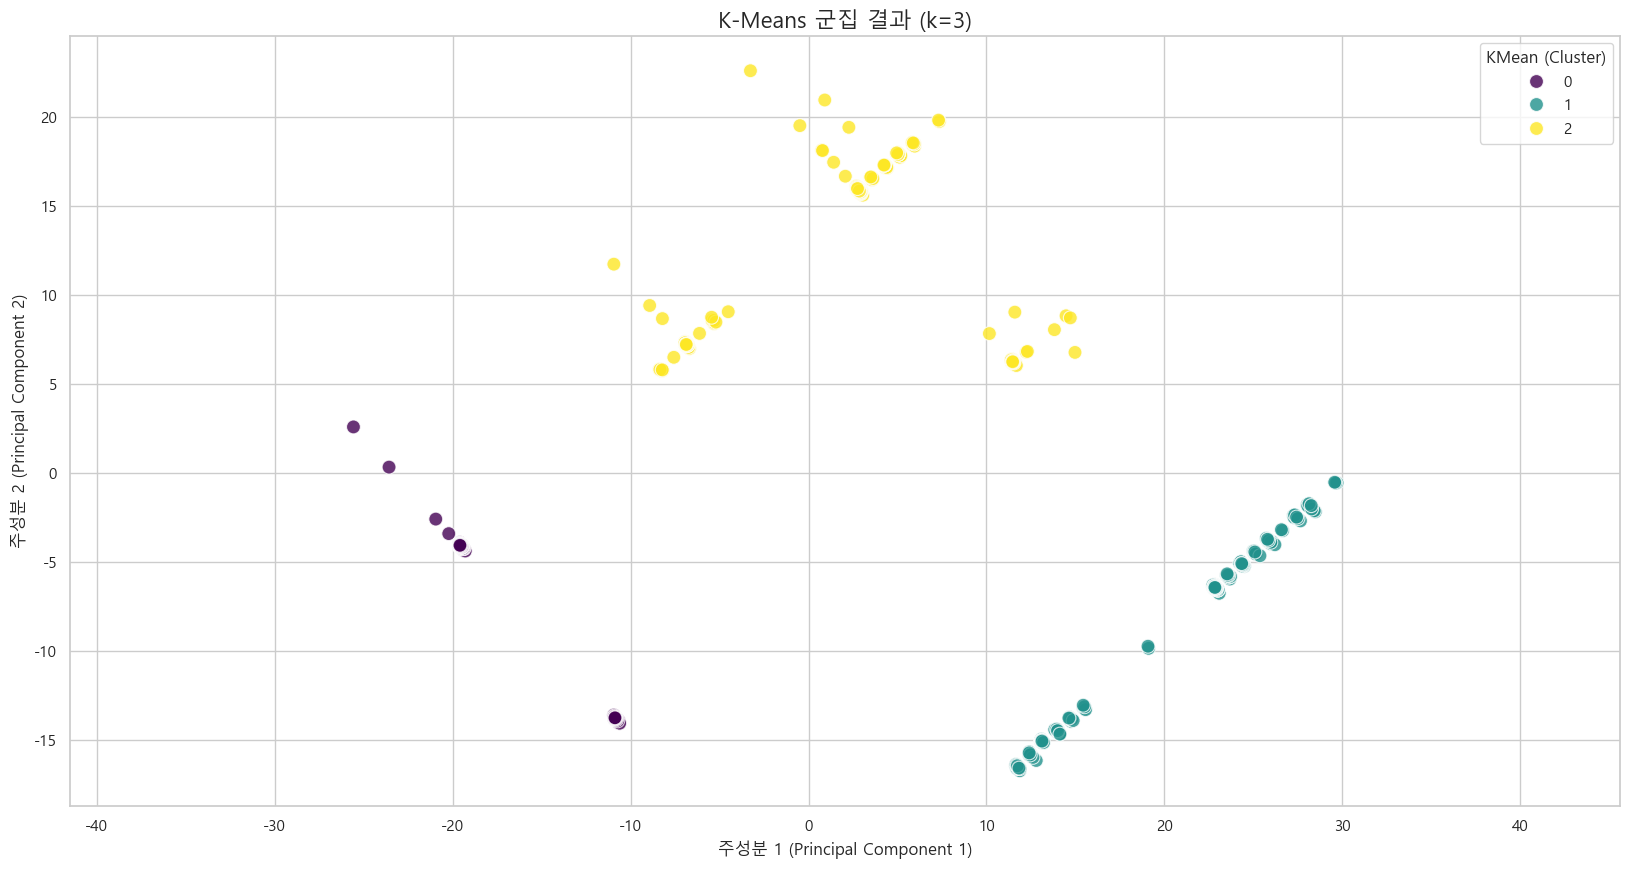

In [87]:
# PCA
from sklearn.decomposition import PCA

# Elbow 결과 기반 k 선택 예시 (여기서는 k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X=travel_fail[CLUSTERING_FEATURES])

travel_fail.loc[:, 'KMEANS_CLUSTER'] = cluster_labels

pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(X=travel_fail[CLUSTERING_FEATURES])

pca_df = pd.DataFrame(data=cluster_pca, columns=['PC1', 'PC2'])
pca_df['CLUSTER'] = cluster_labels

plt.figure(figsize=(20, 10))
sns.scatterplot(x='PC1', y='PC2', hue='CLUSTER', data=pca_df, palette='viridis', s=100, alpha=0.8)
plt.title(f"K-Means 군집 결과 (k={optimal_k})", fontsize=16)
plt.xlabel("주성분 1 (Principal Component 1)", fontsize=12)
plt.ylabel("주성분 2 (Principal Component 2)", fontsize=12)
plt.axis('equal')
plt.legend(title='KMean (Cluster)')
plt.grid(True)
plt.show()

In [81]:
# 실루엣 스코어 출력 (PCA 시각화와 별개)
sil_score = silhouette_score(
    X=pca_df[['PC1', 'PC2']],
    labels=travel_fail['KMEANS_CLUSTER']
)
sil_score

0.8046135903556898

In [82]:
numeric_features = [
    'activity_payment_sum', 'activity_payment_count', 'activity_store_count',
    'activity_history_rows', 'activity_type_unique', 'lodging_payment_sum',
    'lodging_payment_count', 'lodging_store_count', 'visit_trip_days',
    'visit_move_cnt', 'AGE_GRP', 'FAMILY_MEMB', 'INCOME',
    'HOUSE_INCOME', 'TRAVEL_TERM', 'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM'
]

cluster_numeric_summary = travel_fail.groupby('KMEANS_CLUSTER')[numeric_features].mean()

print(cluster_numeric_summary.T)

KMEANS_CLUSTER                      0              1              2
activity_payment_sum    100369.356115  168838.981777  114797.914583
activity_payment_count       3.404676       5.088838       3.822917
activity_store_count         3.149281       4.831435       3.527083
activity_history_rows        7.521583      10.521640       7.818750
activity_type_unique         3.854317       4.305239       3.902083
lodging_payment_sum     127063.363309  136265.410023  128727.808333
lodging_payment_count        0.266187       0.343964       0.277083
lodging_store_count          0.253597       0.316629       0.272917
visit_trip_days              2.251799       2.487472       2.314583
visit_move_cnt               6.816547       9.446469       6.845833
AGE_GRP                     31.816547      27.699317      31.250000
FAMILY_MEMB                  2.593525       2.767654       2.697917
INCOME                       4.264388       3.674260       3.954167
HOUSE_INCOME                 7.401079       7.30

In [83]:
# 분석용 범주형 피처 목록
categorical_features = [
    'TRAVEL_STATUS_ACCOMPANY_CODE', 'MVMN_NM_CODE', 'GENDER_CODE',
    'TRAVEL_STATUS_RESIDENCE_CODE', 'TRAVEL_STATUS_DESTINATION_CODE'
]

# K-Means 군집별 범주형 피처 최빈값
cluster_categorical_summary = travel_fail.groupby('KMEANS_CLUSTER')[categorical_features].agg(lambda x: x.mode()[0])

print(cluster_categorical_summary)


                TRAVEL_STATUS_ACCOMPANY_CODE  MVMN_NM_CODE  GENDER_CODE  \
KMEANS_CLUSTER                                                            
0                                          2             2            2   
1                                          6             1            2   
2                                          2             2            2   

                TRAVEL_STATUS_RESIDENCE_CODE  TRAVEL_STATUS_DESTINATION_CODE  
KMEANS_CLUSTER                                                                
0                                         11                            41.0  
1                                         41                            11.0  
2                                         41                            41.0  


In [84]:
# 각 군집의 분포 확인용 출력
for feature in categorical_features:
    print(f'--- {feature} 분포 ---')
    print(travel_fail.groupby('KMEANS_CLUSTER')[feature].value_counts())
    print()


--- TRAVEL_STATUS_ACCOMPANY_CODE 분포 ---
KMEANS_CLUSTER  TRAVEL_STATUS_ACCOMPANY_CODE
0               2                               174
                6                               152
                8                                84
                5                                66
                1                                48
                3                                16
                7                                16
1               6                               163
                2                               149
                5                                44
                1                                39
                8                                37
                7                                 5
                3                                 2
2               2                               148
                6                                95
                8                                90
                5              

# Success vs. Fail

In [92]:
# --- 데이터 준비---

# 1. 성공 그룹에 대한 K-Means 및 PCA 수행
kmeans_success = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_success = kmeans_success.fit_predict(travel_success[CLUSTERING_FEATURES])
pca_success = PCA(n_components=2)
pca_result_success = pca_success.fit_transform(travel_success[CLUSTERING_FEATURES])
pca_success_df = pd.DataFrame(data=pca_result_success, columns=['PC1', 'PC2'])
pca_success_df['CLUSTER'] = labels_success

# 2. 실패 그룹에 대한 K-Means 및 PCA 수행
kmeans_fail = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels_fail = kmeans_fail.fit_predict(travel_fail[CLUSTERING_FEATURES])
pca_fail = PCA(n_components=2)
pca_result_fail = pca_fail.fit_transform(travel_fail[CLUSTERING_FEATURES])
pca_fail_df = pd.DataFrame(data=pca_result_fail, columns=['PC1', 'PC2'])
pca_fail_df['CLUSTER'] = labels_fail

optimal_k = 3

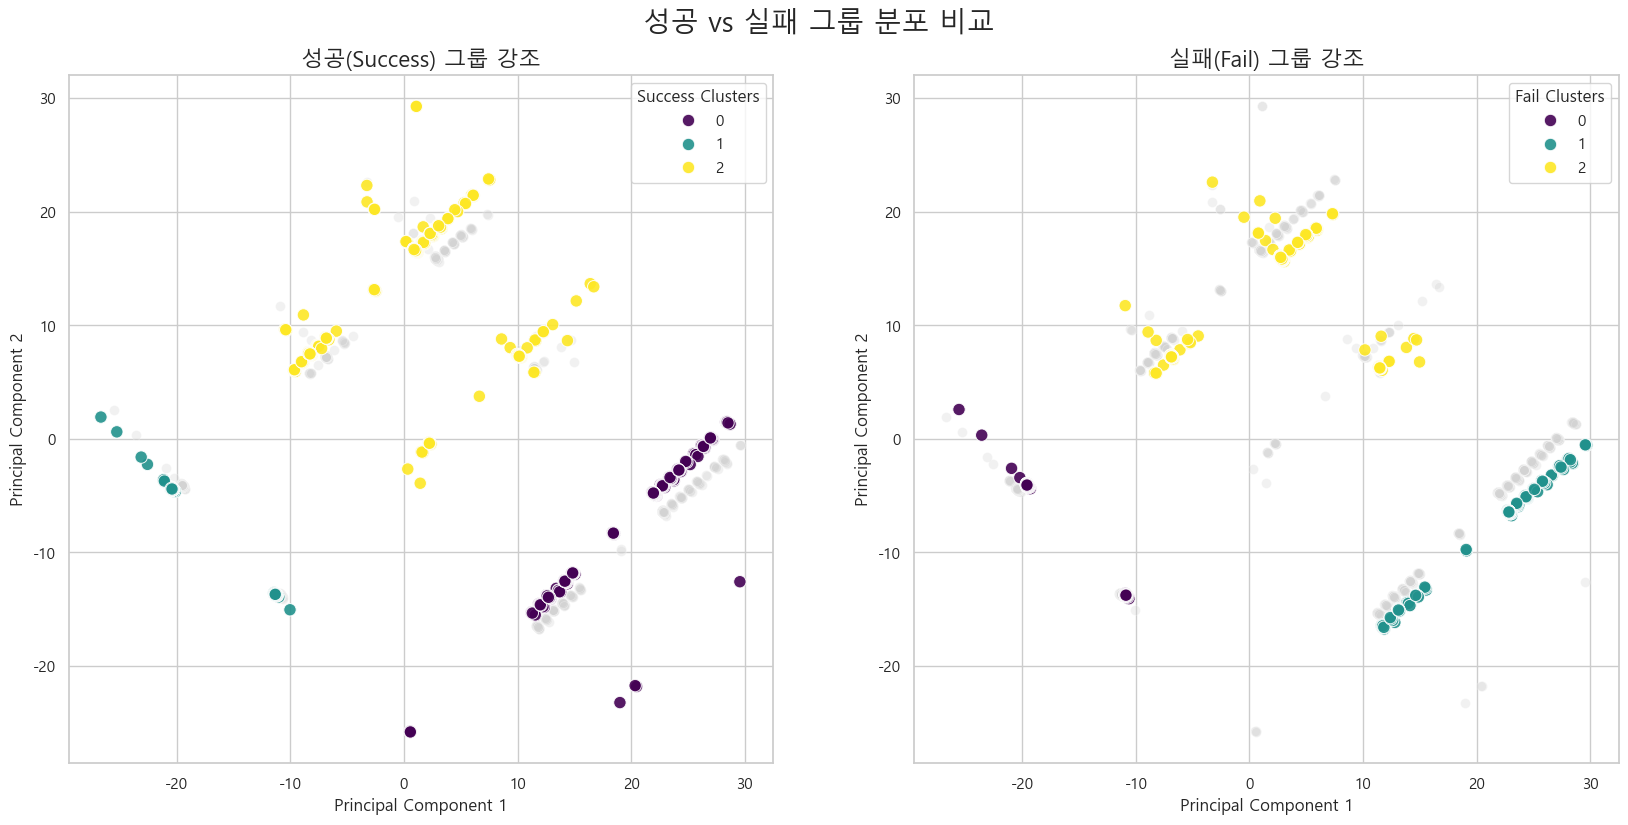

In [93]:
# --- 동일한 스케일로 겹쳐서 시각화 ---

# 1. 1행 2열의 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
fig.patch.set_facecolor('white') # 그림 전체 배경을 흰색으로

# 2. 왼쪽 플롯: 성공(Success) 그룹 강조
# 배경 (실패 그룹)을 연한 회색으로 먼저 그립니다.
sns.scatterplot(data=pca_fail_df, x='PC1', y='PC2', color='lightgrey', alpha=0.3, s=50, ax=ax1, legend=False)
# 강조 (성공 그룹)를 진한 색상으로 그 위에 겹쳐 그립니다.
sns.scatterplot(data=pca_success_df, x='PC1', y='PC2', hue='CLUSTER', palette='viridis', s=80, alpha=0.9, ax=ax1)
ax1.set_title('성공(Success) 그룹 강조', fontsize=16)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.grid(True)
ax1.legend(title='Success Clusters')


# 3. 오른쪽 플롯: 실패(Fail) 그룹 강조
# 배경 (성공 그룹)을 연한 회색으로 먼저 그립니다.
sns.scatterplot(data=pca_success_df, x='PC1', y='PC2', color='lightgrey', alpha=0.3, s=50, ax=ax2, legend=False)
# 강조 (실패 그룹)를 진한 색상으로 그 위에 겹쳐 그립니다.
sns.scatterplot(data=pca_fail_df, x='PC1', y='PC2', hue='CLUSTER', palette='viridis', s=80, alpha=0.9, ax=ax2)
ax2.set_title('실패(Fail) 그룹 강조', fontsize=16)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.grid(True)
ax2.legend(title='Fail Clusters')


# 4. 두 플롯의 전체 축 범위를 계산하여 동일하게 설정 (이전과 동일)
x_min = min(ax1.get_xlim()[0], ax2.get_xlim()[0])
x_max = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
y_min = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')


plt.suptitle('성공 vs 실패 그룹 분포 비교', fontsize=20, y=0.95)
plt.show()